# Классификаторы на основе деревьев принятия решений

### Пример дерева принятия решений

<img src="img/0014-009-.png">

### Пример построения дерева принятия решения по данным

<img src="img/KYSy4.png">
<img src="img/IkBzK.png">

# Определение дерева
Формально, дерево решений - это *связный ациклический граф*. 

В нем можно выделить 3 типа вершин:
1. **Корневая вершина** (root node) -  откуда все начинается
2. **Внутренние вершины** (intermediate/internal nodes) - промежуточные этапе принятия решения, содержат переходы в другие вершины
3. **Листья** (leafs) - самые глубокие вершины дерева, в которых содержится "ответ". Не содержат переходов в другие верины, являются "тупиками".

<center><img src='img/tree-structure.png' style="width: 50%"><center/>
    
Во внутренней или коневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся все глубже. 

В листовой вершине содержится целевая информация.

*Решающее дерево реализует кусочно-постоянную функцию*

## Как определяются лучшие разбиения (best splits)?
### Меры неопределенности (impurity measures)

Пусть $p_k$ - это доля класса $C_k$ в узле дерева $S$.

1. Missclassification error  
$$I(S) = 1 - \max\limits_k p_k $$
2. Gini index 
$$I(S) = 1 - \sum\limits_k (p_k)^2 = \sum\limits_{k'\neq k} p_{k'} p_k$$
3. Entropy 
$$I(S) = -\sum\limits_k p_k \log(p_k)$$


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')                       
plt.rcParams['figure.figsize'] = (18,12)      

In [56]:
# Спасибо Михаилу Трофимову за пример и демонстрашку.

p = np.linspace(0.001, 0.999, 100)  # создать 100 чисел от 0.001 до 0.999
print(p.shape)
p = np.c_[p, 1-p]                   # конкатинирует 2 массива (как функция zip)
                                    # в данном случае мы вектор превратим матрицу высотой 2
print(p.shape)
p[:5]

(100,)
(100, 2)


array([[0.001     , 0.999     ],
       [0.01108081, 0.98891919],
       [0.02116162, 0.97883838],
       [0.03124242, 0.96875758],
       [0.04132323, 0.95867677]])

In [57]:
missclass = 1 - np.max(p, axis=1)
gini = 1 - np.sum(p ** 2, axis=1)
entropy = -1 * np.nansum((p*np.log2(p)), axis=1)    # суммирует, но в случае NaN конвертирует их в 0

print(missclass.shape)
print(missclass[:10])

(100,)
[0.001      0.01108081 0.02116162 0.03124242 0.04132323 0.05140404
 0.06148485 0.07156566 0.08164646 0.09172727]


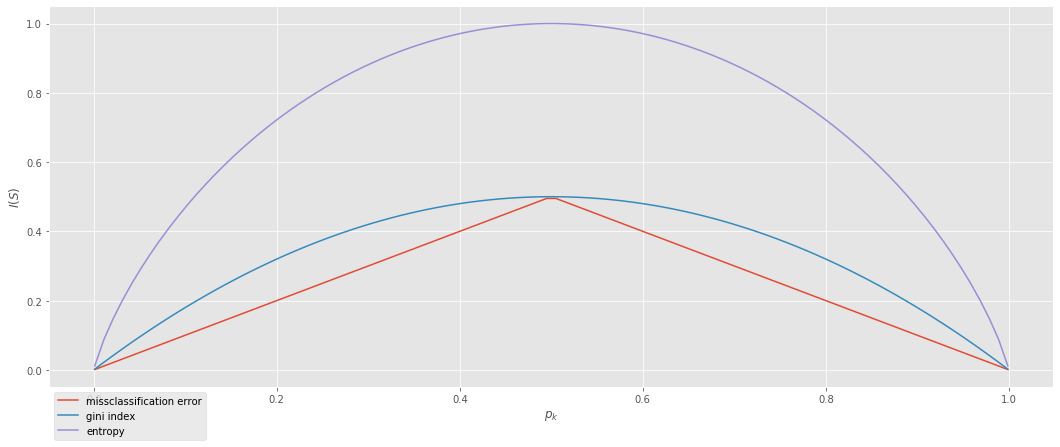

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(7)

plt.plot(p[:,0], missclass, label = 'missclassification error')
plt.plot(p[:,0], gini, label = 'gini index')
plt.plot(p[:,0], entropy, label = 'entropy')

plt.xlabel('$p_k$')
plt.ylabel('$I(S)$')
plt.legend(loc=2, bbox_to_anchor=(0.,0.))

### Расстояние Кулльбака-Лейблера

Расстояние (дивергенция, корреляция) Кулльбака-Лейблера показывает меру сходдства двух распределений.
$$ d_{KL}(P\parallel Q)=\sum\limits_{i=1}^np_i*log(\frac{p_i}{q_i}) $$

<img src="img/KL-Gauss-Example.png">

Может использоваться наравне с корреляцией и ранговой корреляцией, хотя в анализе данных зачастую показывает гораздо лучшие результаты в качестве меры сходства.

### Алгоритмы построения деревьев
 
** ID 3 **
* Только категориальные признаки
* Количество потомков = количеству значений признака
* Строится до максимальной глубины

** С 4.5 **
* Поддержка вещественных признаков
* Категриальные как в ID3
* При пропуске значения переход по всем потомкам
* Удаляет избыточные ветвления

** СART **
* Специальная процедура усечения дерева после построения (post prunning)

Прекрасная визуализация алгоритма обучения и принятия решений находится [здесь](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

### Преимущества и недостатки

**Преимущества:**
* простота построения;
* интерпретируемость (при небольшой глубине);
* требуются минимальная предобработка признаков;
* встроенный отбор признаков;
* произвольное количество классов.

**Недостатки:**
* границы строяется только параллельно или перпендикулярно осям;
* при изменении набора данных надо полностью перестраивать и результат может получится совершенно иным;
* жадность построения.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

from sklearn.tree import export_graphviz
import subprocess

In [13]:
# Спасибо Андрею Шестакову за пример и демонстрашку.

def demo_dec_tree(depth=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))

    np.random.seed(0)

    C = np.array([[0., -0.7], [1.5, 0.7]])
    gauss1 = np.dot(np.random.randn(200, 2) + np.array([4, 2]), C)
    gauss2 = np.dot(np.random.randn(300, 2), C)

    X = np.vstack([gauss1, gauss2])
    y = np.r_[np.ones(200), np.zeros(300)]

    ax[1].scatter(X[:,0], X[:, 1], c=y)
    ax[1].set_xlabel('$x_1$')
    ax[1].set_ylabel('$x_2$')

    # Dec Tree Stuff
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    tree.fit(X,y)

    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)

    Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Y = Y.reshape(xx1.shape)

    ax[1].contourf(xx1, xx2, Y, alpha=0.3)
    ax[1].scatter(X[:,0], X[:,1],c=y)
    
#     dot_data = StringIO()  
#     tree.export_graphviz(tree, out_file=dot_data,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
#     graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#     ax[0].imshow(graph[0].create_png())


    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=['x1', 'x2'], class_names=['0', '1'])
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    ax[0].imshow(plt.imread('tree.png'))
    ax[0].axis("off")
    
    plt.show()

In [14]:
try:
    fig = interact(demo_dec_tree, depth=IntSlider(min=1, max=5, value=1))
except:
    print('Что-то не так. Посмотрите на доску')

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Посмотрим как работают деревья принятия решений на наборе данных "Титаника".

In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import random

In [28]:
titanic = pd.read_csv('data/00_titanic_train.csv')
titanic2 = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

embenc = LabelEncoder()
titanic2.Embarked = titanic2.Embarked.fillna('S')
embenc.fit(titanic2.Embarked)
titanic2.Embarked = embenc.transform(titanic2.Embarked)

sexenc = LabelEncoder()
sexenc.fit(titanic2.Sex)
titanic2.Sex = sexenc.transform(titanic2.Sex)

titanic2.Age = titanic2.Age.map(lambda x: 
                random.uniform(titanic2.Age.mean() - titanic2.Age.std(), titanic2.Age.mean() + titanic2.Age.std()) \
                if x != x else x)



In [29]:
titanic2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


In [30]:
X_train, X_test, y_train, y_test = train_test_split(titanic2.loc[:, 'Pclass' : 'Embarked'], 
                                                    titanic2['Survived'], test_size=0.2)

In [31]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
235,3,0,41.366248,0,0,7.5500,2
168,1,1,38.745650,0,0,25.9250,2
831,2,1,0.830000,1,1,18.7500,2
610,3,0,39.000000,1,5,31.2750,2
717,2,0,27.000000,0,0,10.5000,2
...,...,...,...,...,...,...,...
8,3,0,27.000000,0,2,11.1333,2
425,3,1,17.933961,0,0,7.2500,2
30,1,1,40.000000,0,0,27.7208,0
341,1,0,24.000000,3,2,263.0000,2


In [46]:
tree = DecisionTreeClassifier(criterion='entropy', random_state=300)

In [47]:
tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=300, splitter='best')

In [48]:
y_hat=tree.predict(X_test)

In [49]:
confusion_matrix(y_test, y_hat)

array([[100,  18],
       [ 17,  44]])

In [50]:
precision_recall_fscore_support(y_test, y_hat)

(array([0.85470085, 0.70967742]),
 array([0.84745763, 0.72131148]),
 array([0.85106383, 0.71544715]),
 array([118,  61]))

Немного поиграем с параметрами алгоритма принятия решений.

In [60]:
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

In [66]:
def decideTreeDemo(criterion, max_depth, min_samples_leaf, random_state):
    tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state)
    tree.fit(X_train, y_train)
    y_hat=tree.predict(X_test)
    print(precision_recall_fscore_support(y_test, y_hat))

In [67]:
_ = interact(decideTreeDemo, 
             criterion=Dropdown(options=["gini", "entropy"], value="entropy"),
             max_depth=IntSlider(min=1, max=10, value=3),
             min_samples_leaf=IntSlider(min=1, max=10, value=1),
             random_state=IntSlider(min=100, max=1000, value=300, step=10),
)

interactive(children=(Dropdown(description='criterion', index=1, options=('gini', 'entropy'), value='entropy')…

---

## Случайный лес (Random Forest)

Данные могут быть зашумлены, то есть вектора и классы точек могут быть размечены с ошибками. Постараемся исправить ситуацию при помощи двух нехитрых приемов.

Пусть обучающая выборка состоит из N образцов, размерность пространства признаков равна M, и задан параметр m (в задачах классификации обычно $m\approx \sqrt {M})$ как неполное количество признаков для обучения.

Наиболее распространённый способ построения деревьев комитета следующий.

* Сгенерируем случайную подвыборку с повторениями размером N из обучающей выборки. 
* Построим решающее дерево, классифицирующее образцы данной подвыборки, причём в ходе создания очередного узла дерева будем выбирать набор признаков, на основе которых производится разбиение (не из всех M признаков, а лишь из m случайно выбранных). 
* Дерево строится до полного исчерпания подвыборки и не подвергается процедуре прунинга.

Классификация объектов проводится путём голосования: каждое дерево комитета относит классифицируемый объект к одному из классов, и побеждает класс, за который проголосовало наибольшее число деревьев.

Оптимальное число деревьев подбирается таким образом, чтобы минимизировать ошибку классификатора на тестовой выборке. 

In [51]:
forest=RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
y_hat2=forest.predict(X_test)

In [53]:
confusion_matrix(y_test, y_hat2)

array([[102,  16],
       [ 17,  44]])

In [54]:
precision_recall_fscore_support(y_test, y_hat)

(array([0.85470085, 0.70967742]),
 array([0.84745763, 0.72131148]),
 array([0.85106383, 0.71544715]),
 array([118,  61]))